In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from plotly.subplots import make_subplots
from jupyterthemes import jtplot
jtplot.style()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

telcom = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 数据

In [2]:
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 数据总览

In [3]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


# 数据操作

## 处理tenure

这里有个坑，需要把drop掉空值的telcom重置索引，不然后面的merge会错开合并(索引对不齐)

In [4]:
# 将空格符替换成nan
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)
telcom = telcom[telcom["TotalCharges"].isnull() == False]
# 重置索引，然后把第一列名为index的删去
telcom = telcom.reset_index()[telcom.columns]
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})
# 将No internet service替换成No
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_cols:
    telcom[i] = telcom[i].replace("No internet service","No")

# Tenure to categorical column
def tenure_lab(telcom):
    if telcom['tenure'] <= 12:
        return "Tenure_0-12"
    elif (telcom['tenure'] > 12) & (telcom['tenure'] <= 24):
        return "Tenure_12-24"
    elif (telcom['tenure'] > 24) & (telcom['tenure'] <= 48):
        return "Tenure_24-48"
    elif (telcom['tenure'] > 48) & (telcom['tenure'] <= 60):
        return "Tenure_48-60"
    elif telcom['tenure'] > 60:
        return "Tenure_gt_60"
telcom['tenure_group'] = telcom.apply(lambda x:tenure_lab(x),axis=1)

## 分离churn和not churn

In [5]:
churn = telcom[telcom['Churn'] == 'Yes']
not_churn = telcom[telcom['Churn'] == 'No']

## 分离类别型数据 和数值型数据 

In [6]:
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols = [x for x in telcom.columns if x not in Id_col + target_col + cat_cols]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'tenure_group']

# 数据分析

## 分析客户数据流失整体情况

查看整体的客户流失情况，有26.5%流失

In [7]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

## 按不同特征进行多样化分析

遍历不同特征，查看客户数据流失情况  
1、使用期限越短的客户，越容易流失  
2、电子支票付费的客户，更容易流失  
3、流失客户中，男性和女性各占一半  
4、流失客户中，年轻人占大多数  
5、家里有伴侣或家属的，更容易流失 

In [8]:
def plot_pie(column):

    # Create subplots: use 'domain' type for Pie subplot
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie(labels=churn[column].value_counts().keys().tolist(), 
                         values=churn[column].value_counts().values.tolist(), name="Churn Customers"),
                  1, 1)
    fig.add_trace(go.Pie(labels=not_churn[column].value_counts().keys().tolist(), 
                         values=not_churn[column].value_counts().values.tolist(), name="Not Churn Customers"),
                  1, 2)

    # Use `hole` to create a donut-like pie chart
    fig.update_traces(hole=.6, hoverinfo="label+percent+name")

    fig.update_layout(
        title_text=column + " in customer attrition",
        # Add annotations in the center of the donut pies.
        annotations=[dict(text='Churn Customers', x=0.15, y=0.5, font_size=13, showarrow=False),
                     dict(text='Not Churn Customers', x=0.88, y=0.5, font_size=13, showarrow=False)])
    fig.show()

In [9]:
for column in cat_cols:
    plot_pie(column)

In [10]:
def plot_hist(column):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=churn[column],
        histnorm='percent',
        name='Churn Customers', # name used in legend and hover labels
        opacity=0.75
    ))
    fig.add_trace(go.Histogram(
        x=not_churn[column],
        histnorm='percent',
        name='Not Churn Customers',
        opacity=0.75
    ))

    fig.update_layout(
        title_text=column + " in customer attrition ", # title of plot
        xaxis_title_text=column, # xaxis label
        yaxis_title_text='Percent', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0 # gap between bars of the same location coordinates
    )

    fig.show()

In [11]:
for column in num_cols:
    plot_hist(column)

## 按tenure_group分析客户流失情况

只使用0~12个月的客户，流失率比较大

In [12]:
tg_ch = churn['tenure_group'].value_counts().reset_index()
tg_ch.columns = ['tenure_group','count']
ntg_ch = not_churn['tenure_group'].value_counts().reset_index()
ntg_ch.columns = ['tenure_group','count']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=tg_ch['tenure_group'],
    y=tg_ch['count'],
    name='Churn Customers', # name used in legend and hover labels
    opacity=0.75
))
fig.add_trace(go.Bar(
    x=ntg_ch['tenure_group'],
    y=ntg_ch['count'],
    name='Not Churn Customers',
    opacity=0.75
))

fig.update_layout(
    title_text="tenure_group in customer attrition ", # title of plot
    xaxis_title_text="tenure_group", # xaxis label
    yaxis_title_text='count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0 # gap between bars of the same location coordinates
)

fig.show()

## 按tenure_group和churn分析每月费用和总费用

In [13]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group","Churn"]].head()

,MonthlyCharges,TotalCharges,tenure,tenure_group,Churn
0,29.85,29.85,1,Tenure_0-12,No
1,56.95,1889.50,34,Tenure_24-48,No
2,53.85,108.15,2,Tenure_0-12,Yes
3,42.30,1840.75,45,Tenure_24-48,No
4,70.70,151.65,2,Tenure_0-12,Yes


In [14]:
def plot_tenure_scatter(tenure_group):
    tracer = go.Scatter(x=telcom[telcom['tenure_group']==tenure_group]['MonthlyCharges'],
                        y=telcom[telcom['tenure_group']==tenure_group]['TotalCharges'],
                        mode='markers',
                        name=tenure_group,
                        opacity = .75)
    
    layout = go.Layout(dict(title="Monthly Charges & Total Charges by Tenure group", # title of plot
                            xaxis_title='MonthlyCharges', # xaxis label
                            yaxis_title='TotalCharges', # yaxis label
                            height = 600
                           )
                      )
    
    return tracer,layout

def plot_churn_scatter(churn):
    tracer = go.Scatter(x=telcom[telcom['Churn']==churn]['MonthlyCharges'],
                        y=telcom[telcom['Churn']==churn]['TotalCharges'],
                        mode='markers',
                        name="Churn - " + churn,
                        opacity = .75)
    
    layout = go.Layout(dict(title="Monthly Charges & Total Charges by Churn group", # title of plot
                            xaxis_title='MonthlyCharges', # xaxis label
                            yaxis_title='TotalCharges', # yaxis label
                            height = 600
                           )
                      )
    
    return tracer,layout

In [15]:
data1 = []
data2 = []

for tenure in telcom['tenure_group'].value_counts().sort_index().keys().tolist():
    tracer1,layout1 = plot_tenure_scatter(tenure)
    data1.append(tracer1)

for churn in telcom['Churn'].value_counts().keys().tolist():
    tracer2,layout2 = plot_churn_scatter(churn)
    data2.append(tracer2)

fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
fig1.show()
fig2.show()

## 按tenure_group分析平均每月消费和平均总消费

In [16]:
# 数据分组
avg_tgc = telcom.groupby(['tenure_group','Churn'])[['MonthlyCharges','TotalCharges']].mean().reset_index()
avg_tgc

,tenure_group,Churn,MonthlyCharges,TotalCharges
0,Tenure_0-12,No,46.766169,265.768146
1,Tenure_0-12,Yes,66.493973,288.532064
2,Tenure_12-24,No,54.449589,1018.113493
3,Tenure_12-24,Yes,78.509014,1394.778401
4,Tenure_24-48,No,61.174783,2233.539007
5,Tenure_24-48,Yes,84.500000,3003.136462
6,Tenure_48-60,No,67.579143,3693.971770
7,Tenure_48-60,Yes,88.182500,4762.820000
8,Tenure_gt_60,No,74.440563,5086.077549
9,Tenure_gt_60,Yes,97.317742,6517.167204


In [17]:
# 定义平均值函数
def mean_charges(churn,charge):
    tracer = go.Bar(
        x=avg_tgc[avg_tgc['Churn'] == churn]['tenure_group'],
        y=avg_tgc[avg_tgc['Churn'] == churn][charge],
        name="Churn - " + churn,
        opacity=0.75
        )
    
    layout = go.Layout(
        title="Average " + charge + " by tenure_group", # title of plot
        xaxis_title="tenure_group", # xaxis label
        yaxis_title=charge + " value", # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0 # gap between bars of the same location coordinates
    )
    
    return tracer,layout

In [18]:
# plot1
data1 = []
tracer1,layout1 = mean_charges('Yes','MonthlyCharges')
tracer2,layout2 = mean_charges('No','MonthlyCharges')
data1 = [tracer1,tracer2]
fig1 = go.Figure(data=data1,layout=layout1)

# plot2
data2 = []
tracer3,layout3 = mean_charges('Yes','TotalCharges')
tracer4,layout4 = mean_charges('No','TotalCharges')
data2 = [tracer3,tracer4]
fig2 = go.Figure(data=data2,layout=layout3)

fig1.show()
fig2.show()

## 数据预处理(编码)

将数据进行编码  
1、特性类型为2的进行label encoding  
2、特性类型大于2采用矩阵标签方法编码  
3、数值型特征采用标准化编码

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


df_tel = telcom.copy()
telcom = telcom.drop('tenure_group',axis=1)
#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

# #Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.join(scaled)

## 变量图表总览

当特征很多的时候，用df.describe()很难看到全部信息，需要将行和列置换

In [20]:
summary = df_telcom_og.describe().T.reset_index()
summary.rename(columns={'index':'feature'},inplace=True)
summary = np.around(summary,3)

val_lst = []
for i in summary.columns:
    val_lst.append(summary[i])
trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80]
                 )
layout = go.Layout(dict(title = "Variable Summary"))
table = go.Figure(data=trace,layout=layout)
table.show()

## 使用PCA将特征降维

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
principal_components
pca_data = pd.DataFrame(principal_components,columns = ['PC1','PC2'])
pca_data = pca_data.join(Y)
pca_data['Churn'] = pca_data['Churn'].replace({0:'Not Churn',1:'Churn'})

In [22]:
def pca_scatter(target):
    tracer = go.Scatter(x=pca_data[pca_data['Churn'] == target]['PC1'],
                        y=pca_data[pca_data['Churn'] == target]['PC2'],
                        mode='markers',
                        name=target,
                        text="CustomerId: " + pca_data[pca_data['Churn'] == target]['customerID'],
                        opacity = .75)
    
    layout = go.Layout(dict(title="Visualising data with principal components", # title of plot
                            xaxis_title='principal components 1', # xaxis label
                            yaxis_title='principal components 2', # yaxis label
                            height = 600
                           )
                      )
    
    return tracer,layout
    
data = []
for churn in pca_data['Churn'].value_counts().sort_index().keys().tolist():
    tracer1,layout1 = pca_scatter(churn)
    data.append(tracer1)
fig = go.Figure(data = data,layout = layout1)
fig.show() 

## 客户流失中二元变量的分布（雷达图）

In [23]:
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
dat_rad = telcom[bi_cs]
dat_rad.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,1,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,1,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [24]:
def plot_radar(df,churn_cat,title):
    data_frame = df[df['Churn'] == churn_cat]
    data_frame_x = data_frame.sum().reset_index()
#     data_frame_x = data_frame_x.rename(columns={"index":"feature",0:"Yes"})
    data_frame_x.columns  = ["feature","Yes"]
    data_frame_x['No'] = data_frame.shape[0] - data_frame_x['Yes']
    data_frame_x = data_frame_x[data_frame_x['feature'] != "Churn"]
    
    
    tracer1 = go.Scatterpolar(r=data_frame_x['Yes'].values.tolist(),
                             theta=data_frame_x['feature'].values.tolist(),
                             fill='toself',
                             name='count of 1')
    
    tracer2 = go.Scatterpolar(r=data_frame_x['No'].values.tolist(),
                             theta=data_frame_x['feature'].values.tolist(),
                             fill='toself',
                             name='count of 0')
    
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))

                       
    data = [tracer1,tracer2]
    fig = go.Figure(data = data,layout = layout)
    fig.show()



In [25]:
plot_radar(dat_rad,1,"Churn of Customers")
plot_radar(dat_rad,0,"Not Churn of Customers")

# 数据建模

## 基础模型


 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1268
           1       0.68      0.54      0.60       490

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8003412969283277

 Confusion matrix : 
 [[1144  124]
 [ 227  263]]

 Area under curve :  0.7194714478851477


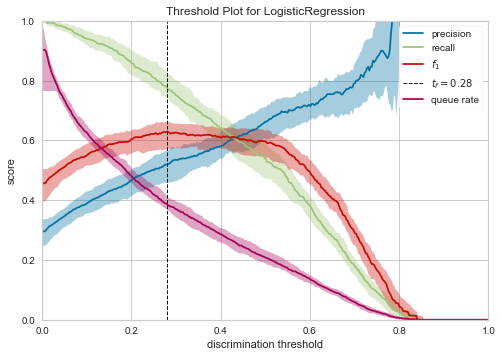

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from plotly.subplots import make_subplots
from yellowbrick.classifier import DiscriminationThreshold

def telecom_churn_prediction(algorithm,train_X,train_y,test_X,test_y,cols,cf,Threshold):
    algorithm.fit(train_X,train_y)
    # 返回预测标签
    predictions = algorithm.predict(test_X)
    # 返回预测属于某标签的概率
    probabilities = algorithm.predict_proba(test_X)
    # 拼接系数和特征
    if cf == 'coefficients':
        coefficients = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == 'features':
        coefficients = pd.DataFrame(algorithm.feature_importances_)
    cols_df = pd.DataFrame(cols)
    summary_df = pd.merge(coefficients,cols_df,left_index=True,right_index=True,how='left')
    summary_df.columns = ['coefficients','feature']
    summary_df = summary_df.sort_values('coefficients',ascending=False)
    print ("\n Classification report : \n",classification_report(test_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(test_y,predictions))
    # 混淆矩阵
    conf_matrix = confusion_matrix(test_y,predictions)
    print("\n Confusion matrix : \n",conf_matrix)
    # 获取AUC值
    model_roc_auc = roc_auc_score(test_y,predictions) 
    print ("\n Area under curve : ",model_roc_auc)
    # 获取ROC曲线所需要的参数
    fpr,tpr,thresholds = roc_curve(test_y,probabilities[:,1])
    
    # 混淆矩阵图
    trace1 = go.Heatmap(z=conf_matrix,
                      x=["Not churn","churn"],
                      y=["Not churn","churn"],
                      showscale  = False,colorscale = "Picnic",
                      name="Matrix")

    # roc曲线图
    trace2 = go.Scatter(x=fpr,
                        y=tpr,
                        name="Roc: " + str(model_roc_auc),
                        opacity = .75)

    trace3 = go.Scatter(x=[0,1],
                        y=[0,1],
                        name="Random Guess",
                        line=dict(dash="dot"),
                        opacity = .75)

    # 特征系数柱状图
    trace4 = go.Bar(x=summary_df['feature'],
                    y=summary_df['coefficients'],
                    name='Churn Customers', # name used in legend and hover labels
                    opacity=0.75)

    fig = make_subplots(rows=2,cols=2,specs=[[{}, {}], [{'colspan': 2,'rowspan': 1}, None]])
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)

    fig['layout'].update(showlegend=False, title="Model performance" ,
                             autosize = False,height = 900,width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))

    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                            tickangle = 90))
    
    fig.show()
    
    if Threshold == True:
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(train_X,train_y)
        visualizer.poof()
    
    
    

# 分离训练集和测试集
train,test = train_test_split(telcom,test_size=0.25,random_state=111)
cols = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_y = train[target_col]
test_X = test[cols]
test_y = test[target_col]

logit = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, 
                           random_state=None, solver='liblinear', max_iter=100,
                           multi_class='ovr', verbose=0, 
                           warm_start=False, n_jobs=1)

telecom_churn_prediction(logit,train_X,train_y,test_X,test_y,cols,'coefficients',Threshold=True)

## Synthetic Minority Oversampling TEchnique (SMOTE)

## Recursive Feature Elimination（RFE）

## Univariate Selection（单变量特征选择）

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

cols = [i for i in telcom.columns if i not in Id_col + target_col]
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

# 卡方检验
select = SelectKBest(chi2,k=3)
fit = select.fit(df_x,df_y)
# print ("scores")
# print (fit.scores_)
# print ("P - Values")
# print (fit.pvalues_)

# 创建新的dataframe
score = pd.DataFrame({'features':cols,'scores':fit.scores_,'pvalues':fit.pvalues_})
score = score.sort_values('scores',ascending=False)
score

# 为分类列和数值列创建新的标签
# score["feature_type"] = np.where(score["feature"].isin(num_cols),"Numerical","Categorical")
score['feature_type'] = score['features'].map(lambda x:'Numerical' if x in num_cols else 'Categorical')

# 画图
trace1 = go.Scatter(x=score[score['feature_type'] == 'Categorical']['features'],
               y=score[score['feature_type'] == 'Categorical']['scores'],
               name="Chi2 Score for Categorical",mode='markers+lines',xaxis='x1',yaxis='y1',
               opacity=0.75)

trace2 = go.Bar(x=score[score['feature_type'] == 'Numerical']['features'],
               y=score[score['feature_type'] == 'Numerical']['scores'],
               name="Chi2 Score for Numerical",xaxis = "x2",yaxis = "y2",
               opacity=0.75)


layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )
fig = go.Figure(data=[trace1,trace2],layout=layout)
fig.show()

## Decision Tree Visualization(决策树分类可视化)

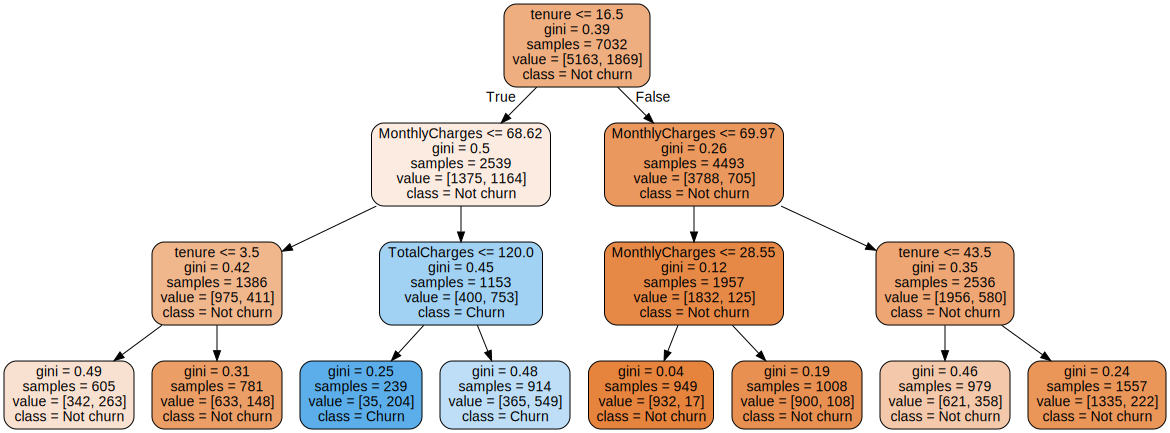

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display


def plot_decision_tree(column,max_depth,criterion_type,splitter_type,model_performance=None):
    # 创建分类器参数
    dtc_x = df_x[column]
    dtc_y = df_y[target_col]

    # 创建决策树分类器
    dt_classifier = DecisionTreeClassifier(max_depth = max_depth,
                                           splitter  = splitter_type,
                                           criterion = criterion_type,)
    dt_classifier.fit(dtc_x,dtc_y)

    # plot 决策树
    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = column, 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True))

    if model_performance == True:
        telecom_churn_prediction(dt_classifier,
                                 dtc_x,dtc_y,
                                 test_X[column],test_y,
                                 column,"features",Threshold = True)
    display(graph)

#top 3 categorical features 
feature_cat = score[score['feature_type'] == 'Categorical']['features'][:3].tolist()
#top 3 numerical features
feature_num = score[score['feature_type'] == 'Numerical']['features'][:3].tolist()

# using top 3 numerical features
plot_decision_tree(feature_num,3,'gini','best',model_performance=False)


 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1268
           1       0.58      0.54      0.56       490

   micro avg       0.76      0.76      0.76      1758
   macro avg       0.70      0.69      0.70      1758
weighted avg       0.76      0.76      0.76      1758

Accuracy   Score :  0.7610921501706485

 Confusion matrix : 
 [[1071  197]
 [ 223  267]]

 Area under curve :  0.6947675915792185


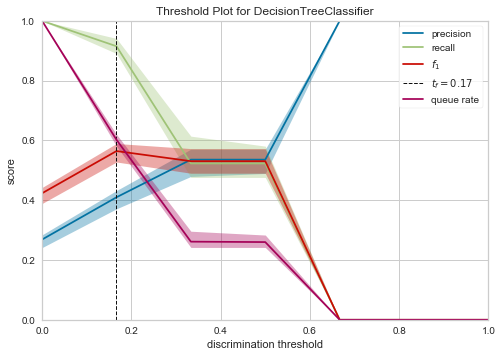

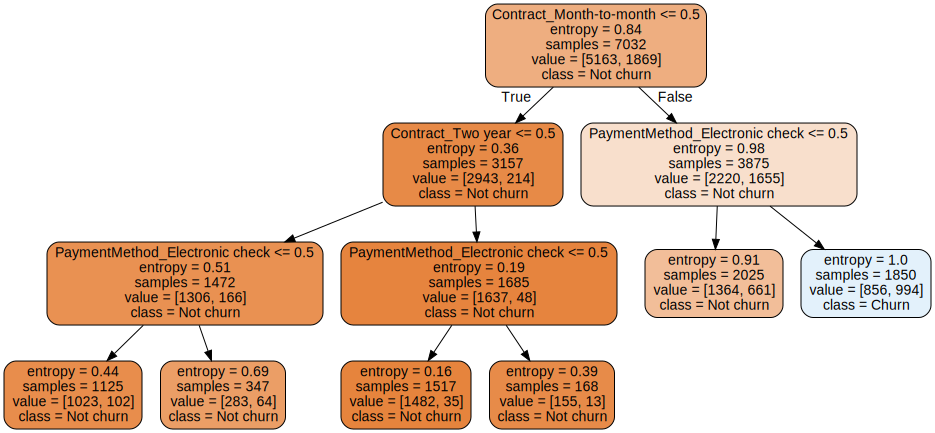

In [60]:
# using top 3 Categorical features
plot_decision_tree(feature_cat,3,'entropy','best',model_performance=True)


 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      1268
           1       0.50      0.66      0.57       490

   micro avg       0.72      0.72      0.72      1758
   macro avg       0.68      0.70      0.68      1758
weighted avg       0.75      0.72      0.73      1758

Accuracy   Score :  0.7218430034129693

 Confusion matrix : 
 [[944 324]
 [165 325]]

 Area under curve :  0.7038724006952939


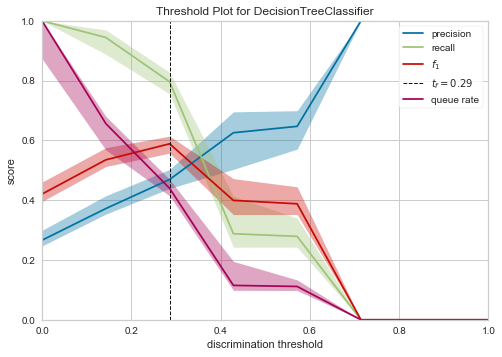

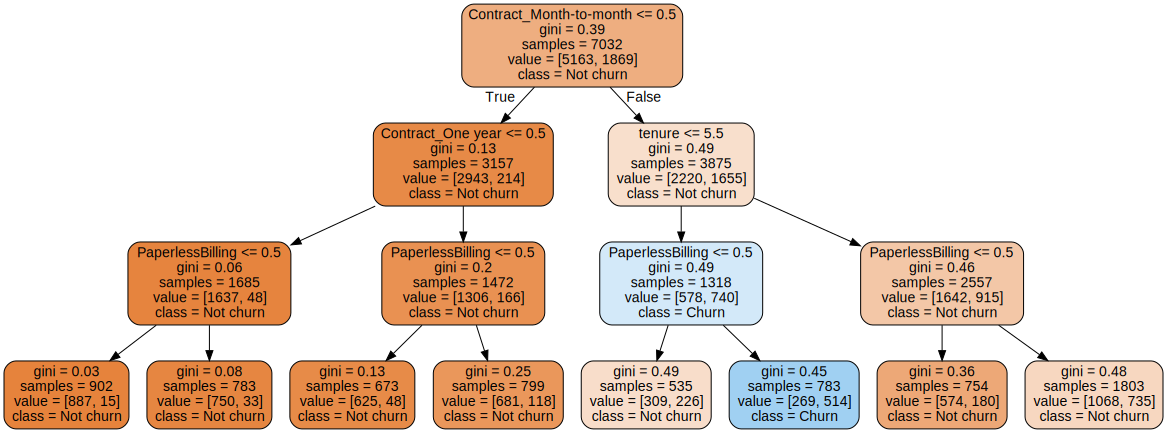

In [61]:
#using contract,tenure and paperless billing variables
columns = ['tenure','Contract_Month-to-month', 'PaperlessBilling',
           'Contract_One year', 'Contract_Two year']
plot_decision_tree(columns,3,"gini","best",model_performance= True)